In [1]:
import sys
print (sys.version)

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import pandas as pd
import numpy as np
from ACDC.cell_type_annotation import * 
from collections import Counter



In [3]:
channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34',
           'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']

path = 'data/BMMC_benchmark/'

df = pd.read_csv(path + 'BMMC_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip')

## discard ungated events
df = df[df.cell_type != 'NotGated']

## log transformation
#df[channels] = np.log(100 + df[channels])
df[channels] = np.arcsinh((df[channels].values - 1.0)/5.0)

## manual gating ground truth
y0 = df.cell_type.values

df = df.drop('cell_type', axis=1)
X0 = df.as_matrix().copy()

## read cell type- marker table
table = pd.read_csv(path + 'BMMC_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)

In [4]:
import pickle
mk_model =  compute_marker_model(df, table, 0.0)

In [5]:
## define some helper dictionaries
idx2ct = [key for idx, key in enumerate(table.index)]
idx2ct.append('unknown')

ct2idx = {key:idx for idx, key in enumerate(table.index)}
ct2idx['unknown'] = len(table.index)
        
ct_score = np.abs(table.as_matrix()).sum(axis = 1)

In [6]:
thres = 0.5

## compute posterior probs
thres = 0.5
score0 = get_score_mat(X0, [], table, [], mk_model)
score0 = np.concatenate([score0, 1.0 - score0.max(axis = 1)[:, np.newaxis]], axis = 1)

## classify events     
ct_index0 = get_unique_index(X0, score0, table, thres)

In [7]:
ave_mat = []
for i, ct in enumerate(table.index):
    if np.any(ct_index0[:, i] == 1):
        item = X0[ct_index0[:, i] == 1, :]
    else:
        item = X0[score0[:, i] > thres, :]
    ave_mat.append(np.mean(item, axis = 0))
ave_mat= np.vstack(ave_mat)    

ct_mat = []
for i, ct in enumerate(table.index):
    ct_mat.append(np.mean(X0[ y0 == ct, :], axis = 0))
ct_mat= np.vstack(ct_mat)    

In [8]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl       
%matplotlib inline


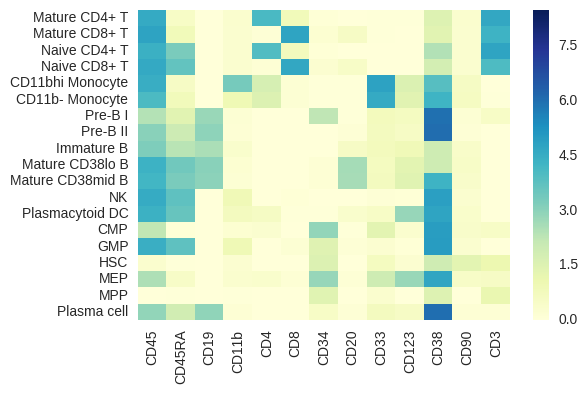

In [12]:
## average heatmap from the score function
fig = plt.figure(figsize=(6, 4))
feature_mat_df = pd.DataFrame(ave_mat, columns = table.columns, index = table.index)

ax = sns.heatmap(feature_mat_df, vmin=0.0, vmax=8.5, cmap="YlGnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

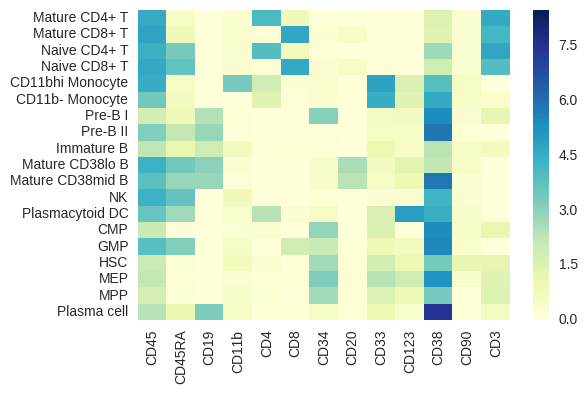

In [13]:
## average heatmap from manual gating
ct_feature_df = pd.DataFrame(ct_mat, columns = table.columns, index = table.index)
ax = sns.heatmap(ct_feature_df, vmin=0.0, vmax=8.5, cmap="YlGnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [14]:
import phenograph

## running phenograph clustering
res_c = get_landmarks(X0, score0, ct_index0, idx2ct, phenograph, thres)
        
landmark_mat, landmark_label = output_feature_matrix(res_c, [idx2ct[i] for i in range(len(idx2ct))]) 

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.512321949005127 seconds
Jaccard graph constructed in 3.310619592666626 seconds
Wrote graph to binary file in 0.6253211498260498 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.651654
After 2 runs, maximum modularity is Q = 0.652961
After 8 runs, maximum modularity is Q = 0.655293
After 10 runs, maximum modularity is Q = 0.657566
Louvain completed 30 runs in 11.139801979064941 seconds
PhenoGraph complete in 17.744080781936646 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8671083450317383 seconds
Jaccard graph constructed in 1.7978568077087402 seconds
Wrote graph to binary file in 0.3592078685760498 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.59972
After 2 runs, maximum modularity is Q = 0.601635
After 4 runs, maximum modularity is Q = 0.605241
Aft

In [15]:
X_plot = [landmark_mat.copy()]
y_plot = landmark_label[:]

for key in idx2ct:
    tmp = X0[y0 == key, :]
    if tmp.shape[0] > 1000:
        ## to remove randomness, we used the first 1000 events
        ## uncomment the following codes for random sampling
        
        #ind_select = np.random.choice(tmp.shape[0], 1000, replace = False)
        #tmp = tmp[ind_select, :]
        tmp = tmp[:1000, :]
        
    y_plot += [key] * tmp.shape[0]
    X_plot.append(tmp)
         
X_plot = np.vstack(X_plot)  
y_plot = np.array(y_plot)

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
Xre = tsne.fit_transform(X_plot) 

([], <a list of 0 Text yticklabel objects>)

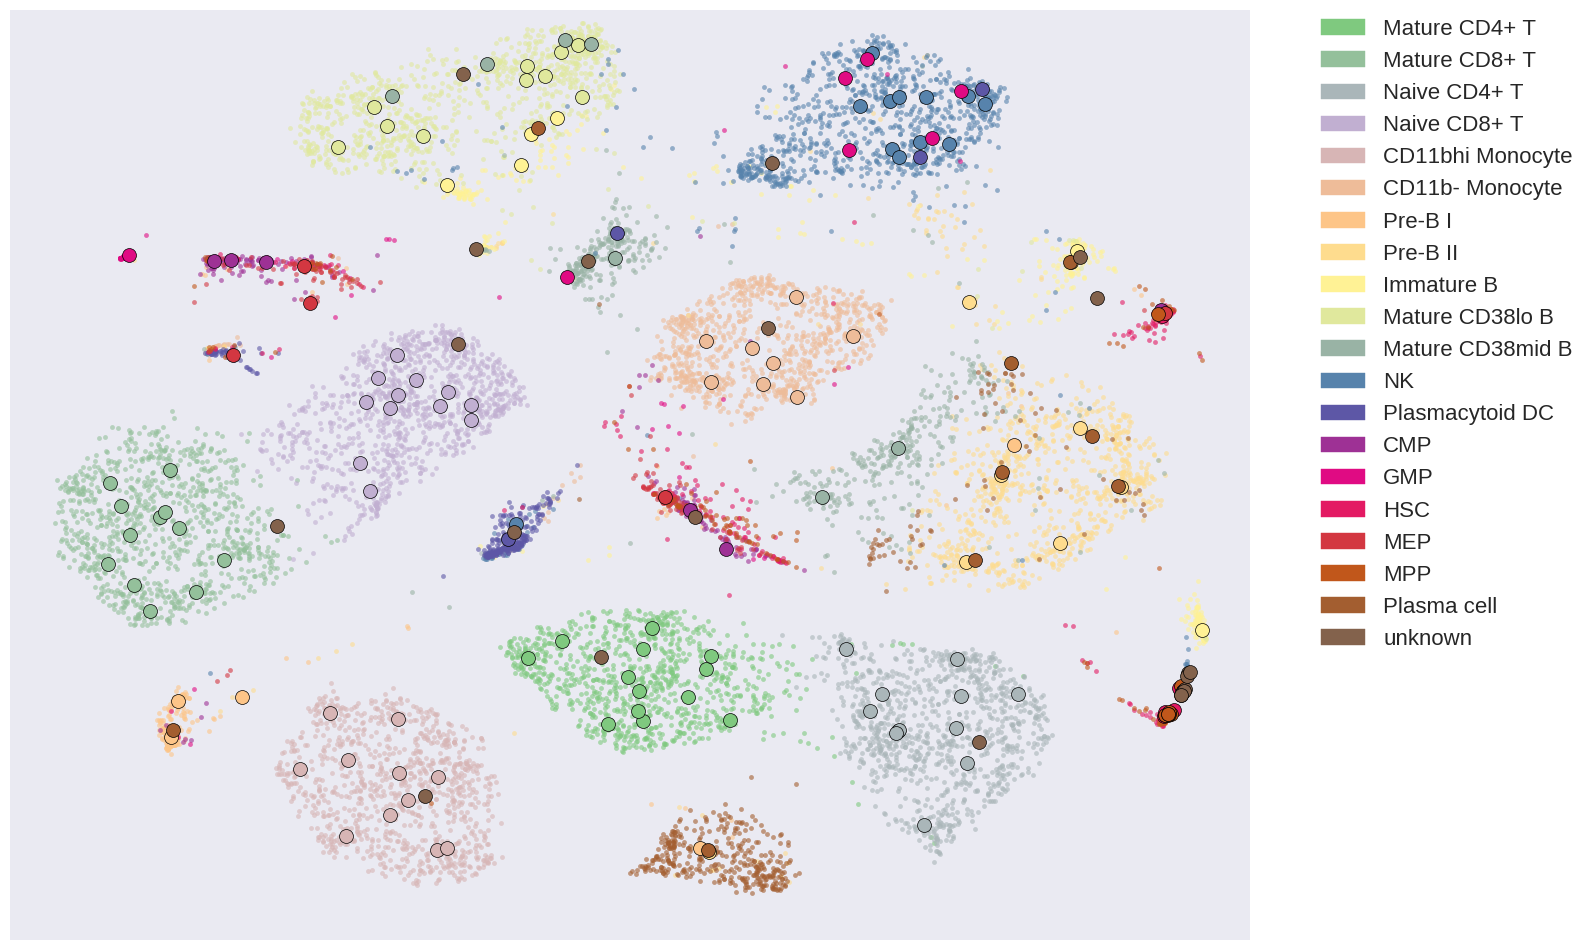

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl   
import matplotlib.patches as mpatches
%matplotlib inline

cmap = mpl.cm.Accent
fig = plt.figure(1, figsize=(16, 12))

for idx, key in enumerate(idx2ct):
    plt.plot(Xre[y_plot == key, 0], Xre[y_plot == key, 1], '.',
                 color=cmap(idx / float(len(idx2ct))), alpha = 0.6, label = key)
       
for idx, key in enumerate(landmark_label):
    ax, ay = Xre[idx, 0], Xre[idx, 1]
    plt.plot(ax, ay, 'o', color=cmap(ct2idx[key] / float(len(idx2ct))),
              alpha = 1, markersize=10, markeredgewidth=0.5)
patches = []
for idx, key in enumerate(idx2ct):
    patches.append(mpatches.Patch(color=cmap(idx / float(len(idx2ct))), label=key))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':16})
        
plt.xticks([])
plt.yticks([])